In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as seabornInstance 

from pandas import merge
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from scipy.stats import pearsonr

%matplotlib inline

from sklearn import preprocessing
pd.options.mode.chained_assignment = None  # default='warn'

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


###  <font color=blue> Importing StreetEasy Data <font>

In [2]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test1_df_ = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
test2_df_ = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
test3_df_ = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)

###  <font color=blue> Importing Additional Data <font>

In [3]:
#https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv/data
dob_complaints_df_ = pd.read_csv('C:/Users/new/Downloads/data/DOB_Complaints_Received.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
#https://data.cityofnewyork.us/Housing-Development/DOB-Violations/3h2n-5cm9/data
dob_violations_df_ = pd.read_csv('C:/Users/new/Downloads/data/DOB_Violations.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
#https://data.cityofnewyork.us/City-Government/Revised-Notice-of-Property-Value-RNOPV-/8vgb-zm6e/data
property_value_df_ = pd.read_csv('C:/Users/new/Downloads/data/Revised_Notice_of_Property_Value__RNOPV_.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# this re-assignment is so there is no need to re-load excel files on each execution
master_df=train_df
test1_df = test1_df_
test2_df = test2_df_
test3_df = test3_df_
dob_complaints_df = dob_complaints_df_
dob_violations_df = dob_violations_df_
property_value_df = property_value_df_

###  <font color=blue> Cleaning and Preprocessing Data <font>

In [71]:
# keeeping only bin number and property values columns for property_value dataset
property_value_df = property_value_df[['BIN','ORIGINAL MARKET VALUE']].copy()

In [8]:
# get number of violations per each bin number and keep only bin nunber and count
dob_violations_df['ISSUE_DATE'] =  pd.to_datetime(dob_violations_df['ISSUE_DATE'], format='%Y%m%d', errors='coerce')
dob_violations_df = dob_violations_df[(dob_violations_df['ISSUE_DATE'].dt.year > 2010) ]
bin_violations = dob_violations_df.BIN.value_counts().reset_index().rename(columns={'index': 'z', 0: 'count'})

In [9]:
# get number of comlaints per each bin number and keep only bin nunber and count
dob_complaints_df['Date Entered'] =  pd.to_datetime(dob_complaints_df['Date Entered'], format='%m/%d/%Y')
dob_complaints_df  = dob_complaints_df[(dob_complaints_df['Date Entered'].dt.year > 2010) ]
bin_complaints = dob_complaints_df.BIN.value_counts().reset_index().rename(columns={'index': 'z', 0: 'count'})

In [10]:
# merge violations df with master df
def add_dob_violations_to_dataset(x):
    #x = pd.merge(left=x,right=bin_violations,  how = 'left', left_on = 'bin', right_on = 'z')
    x = x.merge(right=bin_violations,  how = 'left', left_on = 'bin', right_on = 'z', right_index = True)
    x.rename(columns={'BIN': 'dob_violations_count'}, inplace=True)
    x.drop('z', axis=1, inplace=True)
    return x

# merge complaints df with master df
def add_dob_complaints_to_dataset(x):
    #x = pd.merge(left=x,right=bin_complaints,  how='left', left_on='bin', right_on='z')
    x = x.merge(right=bin_complaints,  how='left', left_on='bin', right_on='z', right_index = True)
    x.rename(columns={'BIN': 'dob_complaints_count'}, inplace=True)
    x.drop('z', axis=1, inplace=True)
    return x
    
# merge property value df with master df
def add_dob_property_tax_to_dataset(x):
    x = pd.merge(left=x,right=property_value_df,  how='left', left_on='bin', right_on='ORIGINAL MARKET VALUE')
    #x = x.merge(right=property_value_df,  how='left', left_on='bin', right_on='ORIGINAL MARKET VALUE', right_index = True)
    x.rename(columns={'ORIGINAL MARKET VALUE': 'market_value'}, inplace=True)
    x.drop('BIN', axis=1, inplace=True)
    return x

In [11]:
# merge additonal data to street easy data
master_df = add_dob_complaints_to_dataset(master_df)
master_df = add_dob_violations_to_dataset(master_df)
#master_df = add_dob_property_tax_to_dataset(master_df)

###  <font color=blue> Handle Training Data Missing Values <font>

In [12]:
# features
feature_cols = [
    'bedrooms', 'year_built', 'bathrooms', 'min_to_subway', 'size_sqft', 'no_fee', 'addr_zip', 'floornumber', 'floor_count', 
    'has_doorman', 'has_fireplace', 'has_gym', 'allows_pets', 'has_washer_dryer', 'has_garage',
    'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden', 'dob_complaints_count', 'dob_violations_count'
]

def fill_missing_values(train_features):
    train_features = train_features.fillna({
        'bedrooms': train_features['bedrooms'].median(),
        'bathrooms': train_features['bathrooms'].median(),
        'size_sqft': train_features['size_sqft'].median(), 
        'floornumber': train_features['floornumber'].median(),
        #'market_value': train_features['market_value'].median(),
        'floor_count': train_features['floor_count'].mean(),
        'year_built': train_features['year_built'].mean(),
        'min_to_subway': train_features['min_to_subway'].mean(),
        'no_fee': 0,
        'has_doorman':0, 
        'has_fireplace':0, 
        'has_gym':0, 
        'allows_pets':0, 
        'has_washer_dryer':0, 
        'has_garage':0,
        'has_roofdeck':0, 
        'has_concierge':0, 
        'has_pool':0, 
        'has_garden':0,
        'dob_complaints_count':0, 
        'dob_violations_count':0
    }) 
    return train_features

In [13]:
# Getting rid of the top 5 percent by normalizing all rents based on range of rents

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

#rents = normalize(master_df['rent'].values)
#rents = list(filter(lambda x: x < 0.95, rents))

###  <font color=blue> Handle Outliers <font>

In [14]:
master_df = master_df[( master_df['size_sqft'] < 2300) ]
master_df = master_df[( master_df['size_sqft']  >  0) ]
master_df = master_df[(master_df['bedrooms'] > 0) ]
master_df = master_df[(master_df['bedrooms'] < 6) ]
master_df = master_df[(master_df['rent'] < 10000) ]
master_df = master_df[(master_df['bathrooms'] < 4) ]
master_df = master_df[(master_df['floor_count'] < 50) ]

master_df = fill_missing_values(master_df)
train_features = master_df[feature_cols] 

train_target = master_df['rent']

## <font color=blue> Visualization of Data <font>


In [15]:
# detemrine correaltion between rent and other variables

a = ['bedrooms', 'bathrooms', 'size_sqft', 'floornumber', 'floor_count','year_built' ,'min_to_subway','no_fee','has_doorman' , 'has_fireplace' , 'has_gym' , 'allows_pets' ,'has_washer_dryer' , 'has_garage' ,'has_roofdeck' , 'has_concierge' , 'has_pool' , 'has_garden' ,'dob_complaints_count' , 'dob_violations_count']

print('Pearsons correlation\n')

for i in a:
    corr, _ = pearsonr(master_df['rent'], master_df[i])
    print('rent,'+ i + ':   ' + str(corr))


Pearsons correlation

rent,bedrooms:   0.27337677381842257
rent,bathrooms:   0.5527887434545751
rent,size_sqft:   0.5469084167526223
rent,floornumber:   0.3570015840123431
rent,floor_count:   0.41815669201383443
rent,year_built:   0.015166523674685193
rent,min_to_subway:   0.005224310980943955
rent,no_fee:   0.18239969924821792
rent,has_doorman:   0.43850987444994555
rent,has_fireplace:   0.11967971577972973
rent,has_gym:   0.4018195070745489
rent,allows_pets:   0.23703890420894053
rent,has_washer_dryer:   0.42598110185281973
rent,has_garage:   0.1964421082490106
rent,has_roofdeck:   0.3195248625211325
rent,has_concierge:   0.39281141554667237
rent,has_pool:   0.19344629636965002
rent,has_garden:   0.16327078232199735
rent,dob_complaints_count:   nan
rent,dob_violations_count:   nan


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


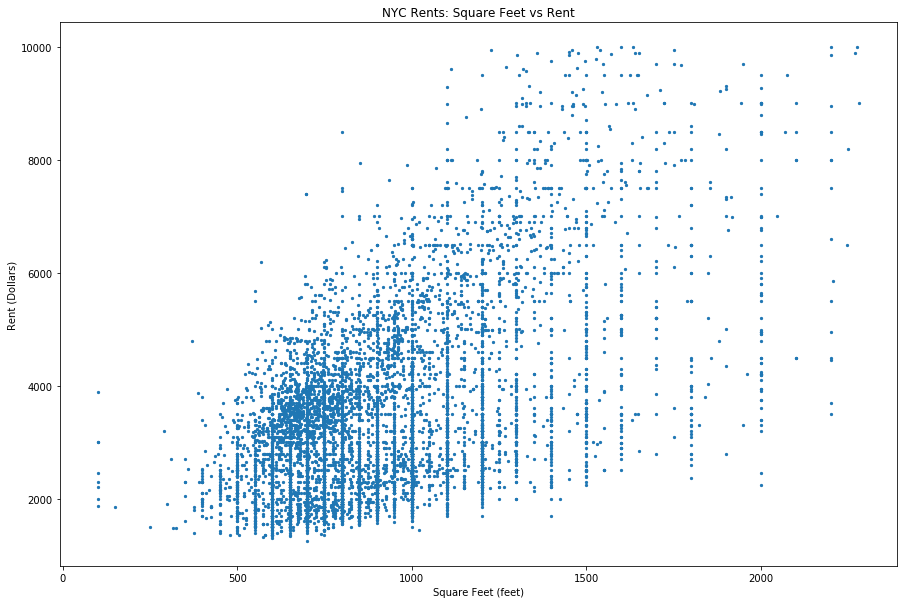

In [16]:
plt.figure(figsize=(15,10))
plt.scatter( master_df['size_sqft'], master_df['rent'],  s=5)
plt.title("NYC Rents: Square Feet vs Rent")
plt.xlabel("Square Feet (feet)")
plt.ylabel("Rent (Dollars)")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


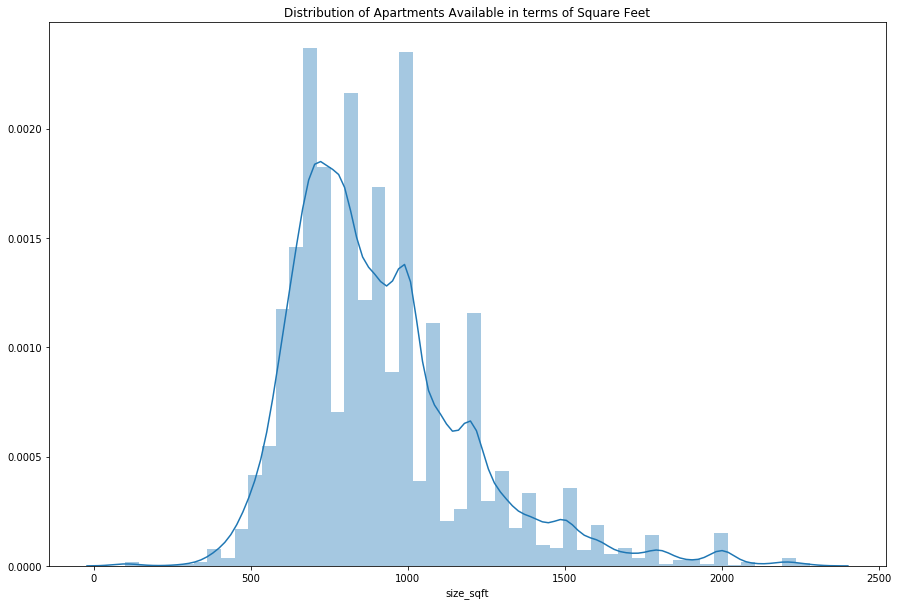

In [17]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of Apartments Available in terms of Square Feet')
seabornInstance.distplot(master_df['size_sqft'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


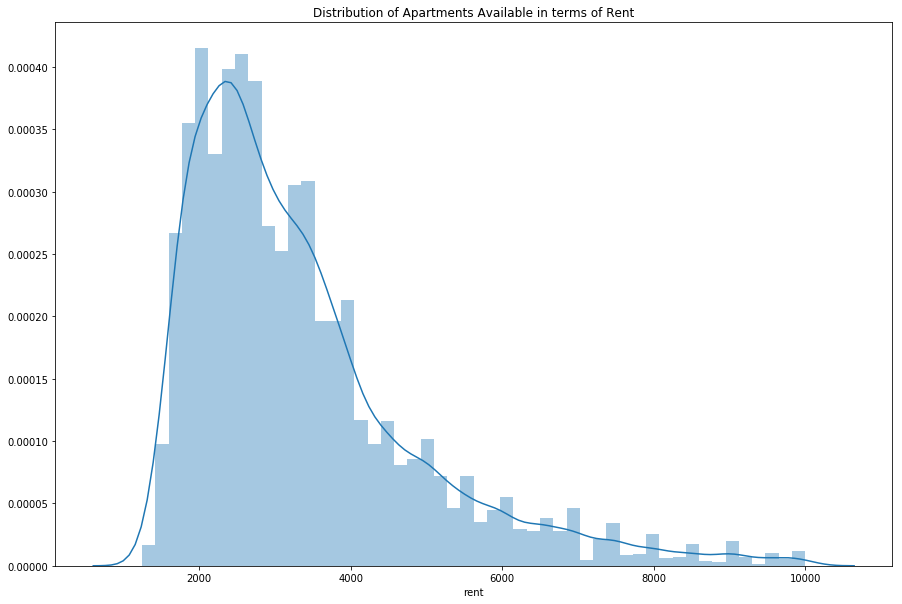

In [18]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of Apartments Available in terms of Rent')
seabornInstance.distplot(master_df['rent'])

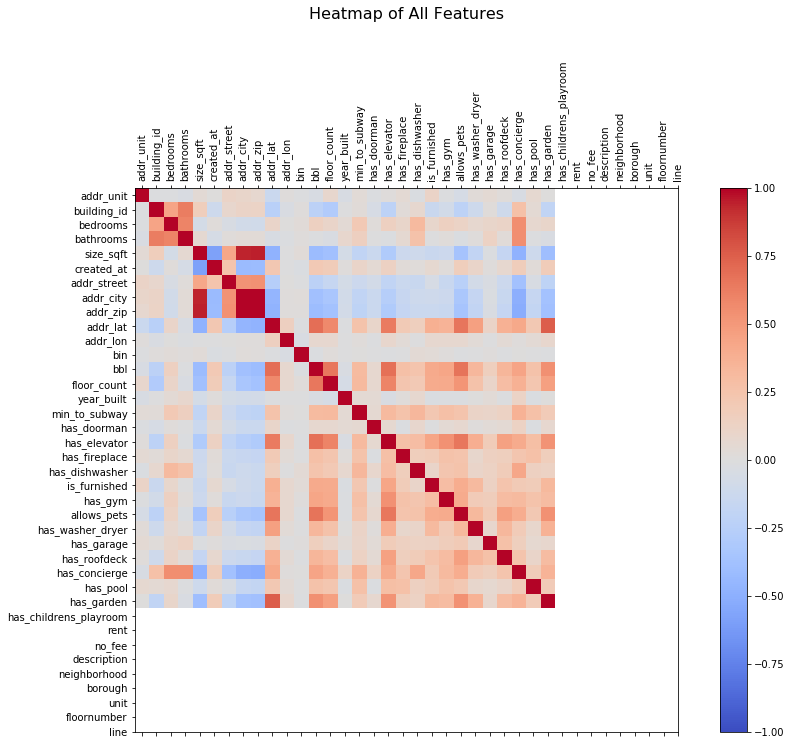

In [19]:
temp=master_df.iloc[:,1:-1]
corr = temp.corr()
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(temp.columns),1)

ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_df.columns)
ax.set_yticklabels(train_df.columns)
plt.title('Heatmap of All Features', y=1.3, fontsize = 16)
plt.show()

Text(0.5,1,'Apartments Available (Grid)')

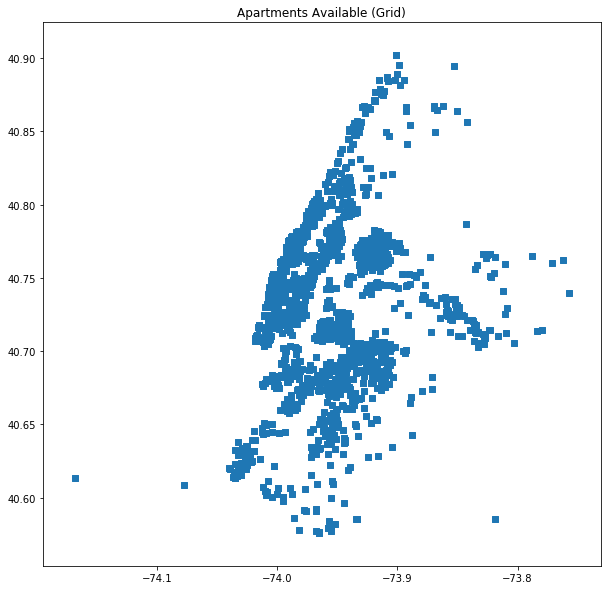

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(test1_df['addr_lon'],test1_df['addr_lat'], marker = ',')
plt.title('Apartments Available (Grid)')

#  <font color=green> Test 1 <font>

In [ ]:
#master_df.head(1)

In [ ]:
# impute missing values 
test1_df = add_dob_complaints_to_dataset(test1_df)
test1_df = add_dob_violations_to_dataset(test1_df)
test1_df = fill_missing_values(test1_df)

test1_features = test1_df[feature_cols]

#### Impute Missing Values 

In [21]:

test1_df = add_dob_complaints_to_dataset(test1_df)
test1_df = add_dob_violations_to_dataset(test1_df)
test1_df = fill_missing_values(test1_df)

test1_features = test1_df[feature_cols]

#### Linear Regression Model

In [22]:
lreg = LinearRegression()
lreg.fit(train_features, train_target)

test1_df['predicted'] = lreg.predict(test1_features)
mean_squared_error(test1_df['rent'], test1_df['predicted'])

3546992.690203936

#### Random Forest Regression Model


In [23]:
regressor = RandomForestRegressor(n_estimators = 50, random_state = 1, max_depth = 42)
regressor.fit(train_features, train_target)

test1_df['predicted'] = regressor.predict(test1_features)
mean_squared_error(test1_df['rent'], test1_df['predicted'])

3666514.2933104

#### Visualize Predicitons

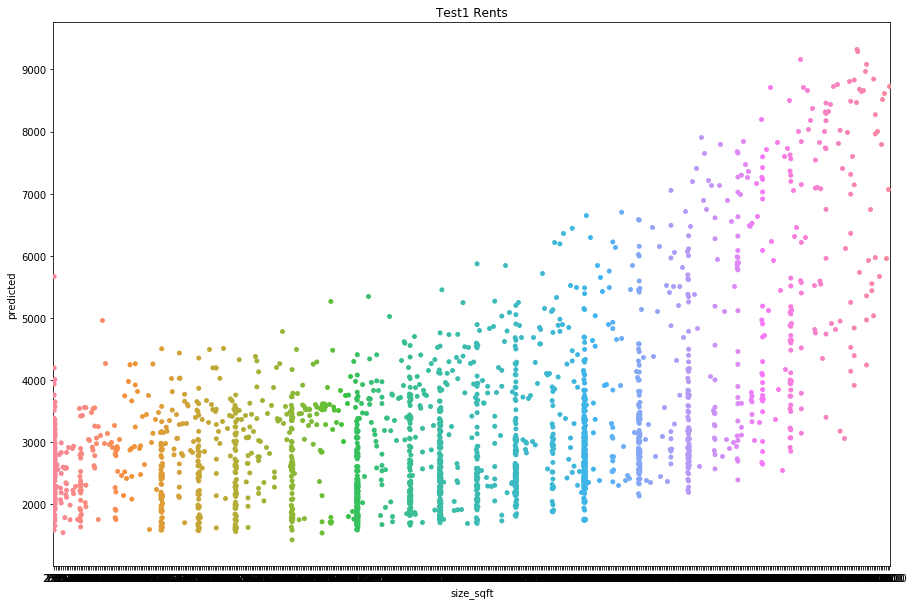

In [24]:
plt.figure(figsize=(15,10))
plt.title("Test1 Rents")
seabornInstance.swarmplot(x="size_sqft", y="predicted", data=test1_df)

#  <font color=green> Test 2 <font>


#### Combine Train Data and test1 data

In [25]:
master_df = master_df.append(test1_df, sort=False) 

#### Impute Missing Values 

In [26]:
# impute missing values with medians
test2_df = add_dob_complaints_to_dataset(test2_df)
test2_df = add_dob_violations_to_dataset(test2_df)
test2_df = fill_missing_values(test2_df)

test2_features = test2_df[feature_cols]

#### Random Forest Regression Model

In [27]:
master_target = master_df['rent']
master_features = master_df[feature_cols]
master_features = fill_missing_values(master_features)

regressor.fit(master_features, master_target)
test2_df['rent'] = regressor.predict(test2_features)

In [28]:
test2_df['rent'].to_csv('test2_results.csv', header=True)

#### Visualize Predicitons

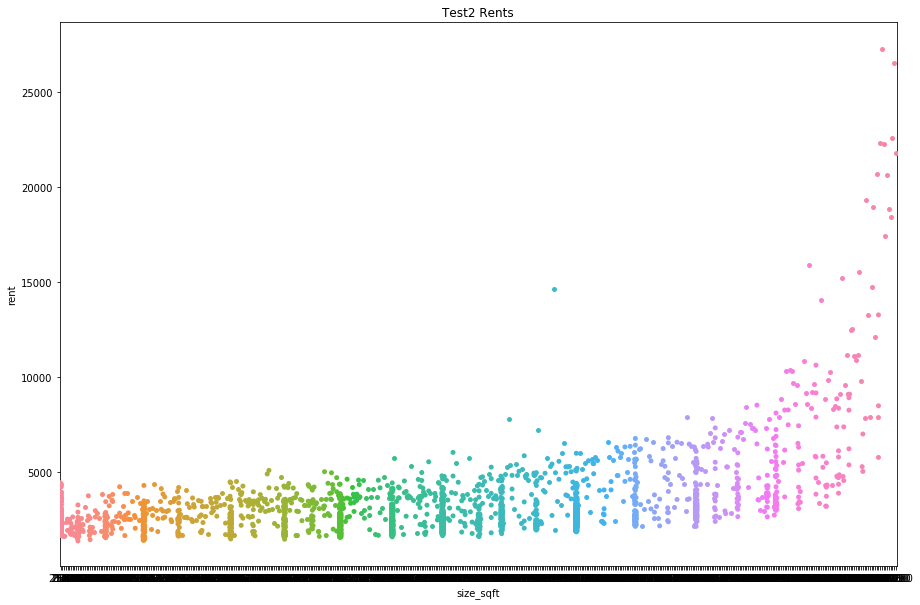

In [29]:
plt.figure(figsize=(15,10))
plt.title("Test2 Rents")
seabornInstance.swarmplot(x="size_sqft", y="rent", data=test2_df)

#  <font color=green> Test 3 <font>


#### Combine Train Data and test1 data

In [30]:
master_df = master_df.append(test2_df,  sort=False) 

#### Impute Missing Values 

In [31]:
# impute missing values 
test3_df = add_dob_complaints_to_dataset(test3_df)
test3_df = add_dob_violations_to_dataset(test3_df)
test3_df = fill_missing_values(test3_df)

test3_features = test3_df[feature_cols]

#### Handle Training Data Missing Values

In [32]:
master_target = master_df['rent']
master_features = master_df[feature_cols]
master_features = fill_missing_values(master_features)

regressor.fit(master_features, master_target)
test3_df['rent'] = regressor.predict(test3_features)

In [33]:
test3_df['rent'].to_csv('test3_results.csv', header=True)

#### Visualize Predicitons

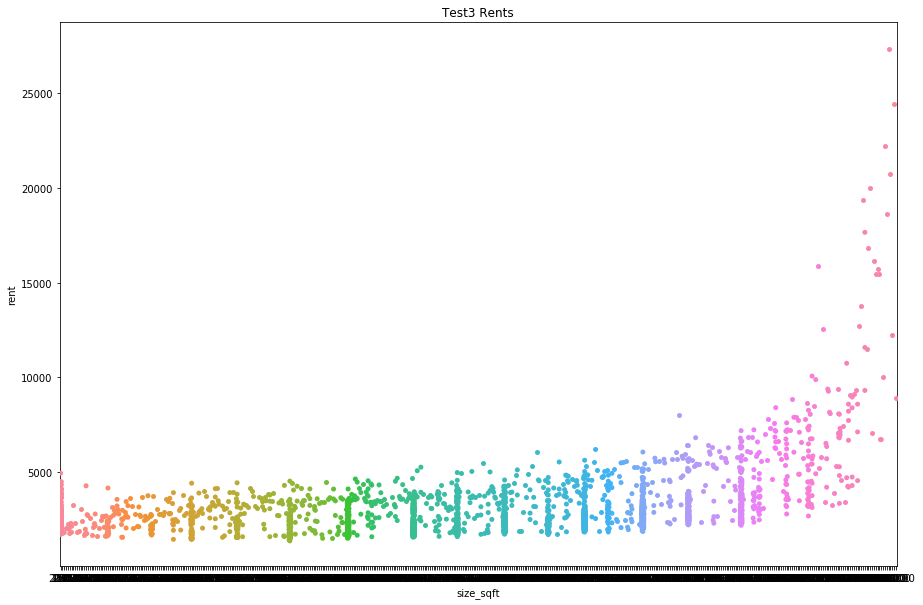

In [34]:
plt.figure(figsize=(15,10))
plt.title("Test3 Rents")
seabornInstance.swarmplot(x="size_sqft", y="rent", data=test3_df)

In [ ]:
#df = master_df[(master_df['dob_violations_count'] != 'NaN') ]
#gb = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
#gb.fit(train_features, train_target)
#test1_df['predicted'] = gb.predict(test_features)
#mean_squared_error(test1_df['rent'], test1_df['predicted'])
#3487743.630438365
#2674320.2628589286


#master_df.head(5)
gb = GradientBoostingRegressor()
gb.fit(train_features, train_target)

test1_features = test1_df[feature_cols]
test1_features = test1_features.fillna(master_df.median(), axis=0)
test1_features = pd.get_dummies(test1_features)

test1_df['predicted'] = gb.predict(test1_features)
mean_squared_error(test1_df['rent'], test1_df['predicted'])